In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
import sympy as sy

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

# Definición del sistema

In [3]:
system = mm.System()
mass = (12.010*15.999)/(12.010+15.999) * unit.amu # masa reducidad de la molecular diatómica: C-O
print('Masa:',mass)
system.addParticle(mass)

Masa: 6.86022314256132 Da


0

# Paisaje de energía potencial

In [4]:
def harmonic_well(x,K):
    return 0.5*K*x**2

In [5]:
K=100.0

In [6]:
x_serie = np.arange(-5., 5., 0.05)

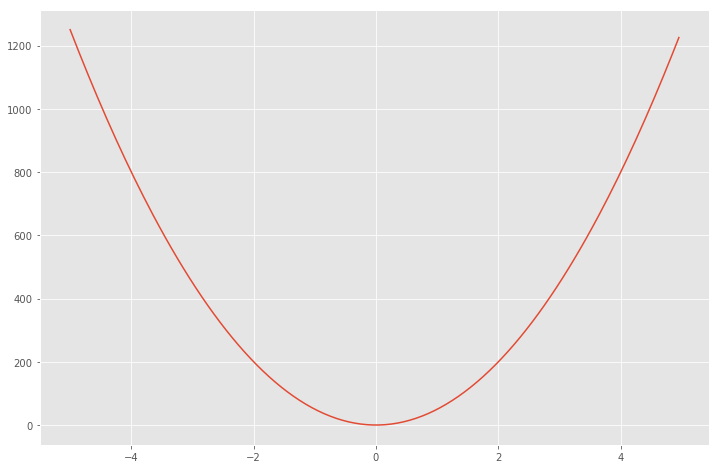

In [7]:
plt.plot(x_serie, harmonic_well(x_serie,K))

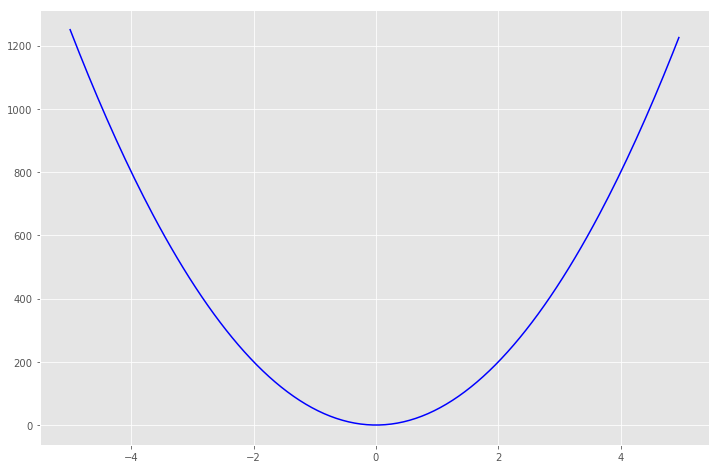

In [8]:
plt.plot(x_serie, harmonic_well(x_serie,K), 'b')

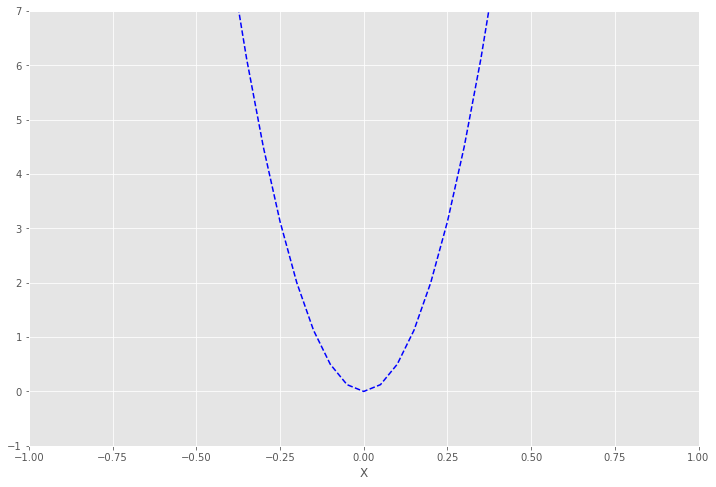

In [9]:
plt.plot(x_serie, harmonic_well(x_serie,K), 'b--')
plt.ylim(-1,7)
plt.xlim(-1,1)
plt.xlabel("X")
plt.show()

In [10]:
x = sy.symbols('x')

In [11]:
f=0.5*K*x**2

In [12]:
f

50.0*x**2

In [13]:
g=sy.diff(f,x)

In [14]:
g

100.0*x

In [15]:
gg=sy.diff(f,x,x)

In [16]:
gg

100.000000000000

In [17]:
roots_diff=sy.roots(g,x)

In [18]:
roots_diff

{0: 1}

In [19]:
print('Calculamos las raices:')
print('')
print('Función:',f)
print('Primera derivada:',g)
print('Segunda derivada:',gg)

Calculamos las raices:

Función: 50.0*x**2
Primera derivada: 100.0*x
Segunda derivada: 100.000000000000


In [20]:
roots_x=[]
for root in roots_diff.keys():
    effective_k=gg.subs(x,root)
    if effective_k>0:
        roots_x.append(root)
        T = 2*np.pi*np.sqrt(mass/(effective_k * unit.kilocalories_per_mole/unit.angstrom**2))
        print('Minimo en coordenada',root,'con k effectiva',effective_k,' y un periodo T de oscilación',T)

Minimo en coordenada 0 con k effectiva 100.000000000000  y un periodo T de oscilación 0.08045502081776873 ps


In [21]:
force = mm.CustomExternalForce('(K/2.0) * (x^2 + y^2 + z^2)')

In [22]:
force.addGlobalParameter('K', K * unit.kilocalories_per_mole/unit.angstrom**2)

0

In [23]:
force.addParticle(0, [])

0

In [24]:
system.addForce(force)

0

# Estado termodinámico

In [25]:
temperature = 500.0*unit.kelvin

In [26]:
pressure    = None

# Parámetros de simulación

In [27]:
step_size       = 0.004*unit.picoseconds
num_steps       = 400000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

# Integrador

In [28]:
friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Plataforma de simulación

In [29]:
platform_name = 'CUDA'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"

In [30]:
platform = mm.Platform.getPlatformByName(platform_name)

# Reporteros y arrays de salida

In [31]:
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)

In [32]:
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)

In [33]:
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)

In [34]:
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

In [35]:
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

# Condiciones iniciales 

In [36]:
initial_positions  = [[0.0, 0.0, 0.0]] * unit.angstroms

In [37]:
context = mm.Context(system, integrator, platform)

In [38]:
context.setPositions(initial_positions)

In [39]:
context.setVelocitiesToTemperature(temperature)

In [40]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)

In [41]:
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Corriendo la simulación

In [42]:
for ii in range(1,num_steps_saved):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

# Análisis de resultados

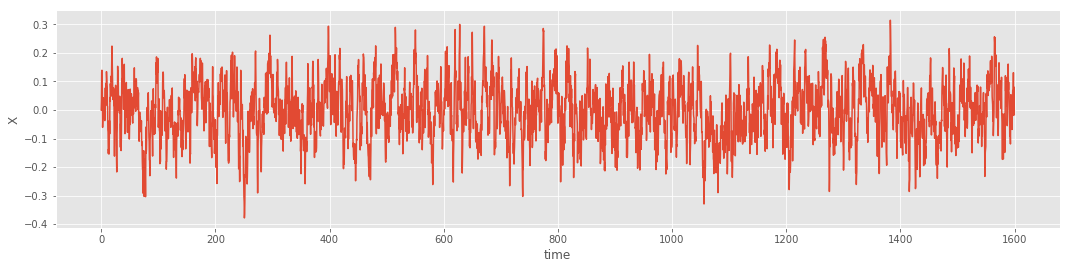

In [43]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,positions[:,0])
plt.ylabel('X')
plt.xlabel('time')
plt.show()

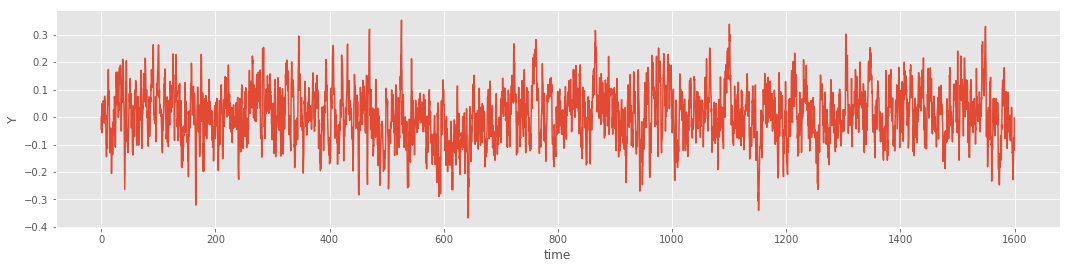

In [44]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,positions[:,1])
plt.ylabel('Y')
plt.xlabel('time')
plt.show()

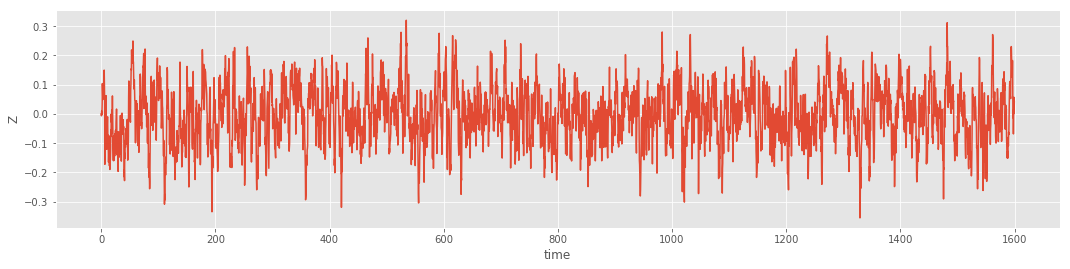

In [45]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,positions[:,2])
plt.ylabel('Z')
plt.xlabel('time')
plt.show()

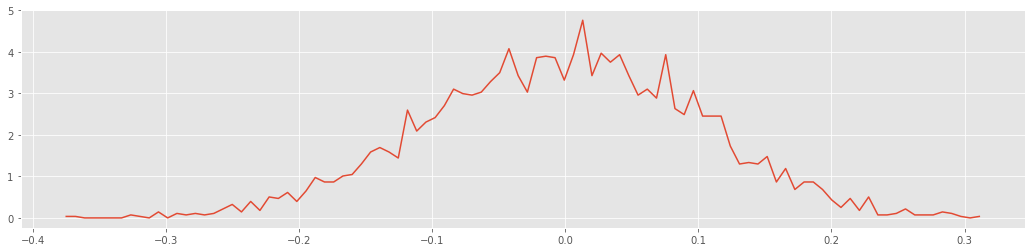

In [46]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)

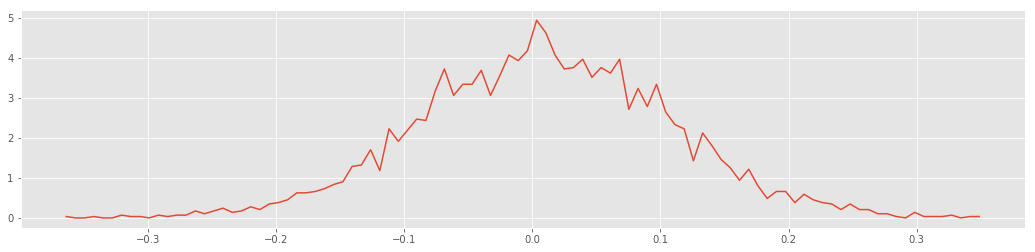

In [47]:
hist, bin_edges = np.histogram(positions[:,1],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)

/home/diego/Myopt/Miniconda/miniconda3/envs/UIBCDF_lab/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


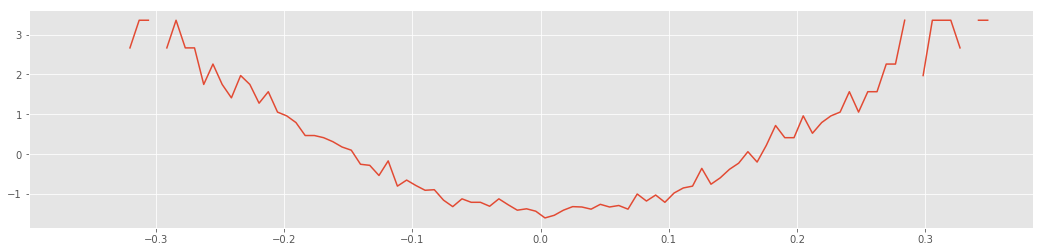

In [48]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))

Notas:

- Es un buen sitio para ilustrar lo que es un forcefield y cómo se ajustan. Podríamos buscar el paper de frecuencia de vibración y ajustar la K.
- También es otro muy buen sitio para ver lo siguiente:
   - Le paso de integración mayor de $~0.1*T$ puede causar graves problemas de integración
   - El papel del damping y la temperatura en el termostato:
      - Oscilador clásico sin damping ni temperatura
      - Oscilardor amortiguado sin temperatura
      - Oscilador sobre amortiguado
      - Oscilador amortiguado con temperatura
      - Oscilador sobre amortiguado con rampa de temperatura... excitación de oscilaciones  hasta tener ruido.
      - Si desconectamos el damping y dejamos temperatura?
   - Principio de equipartición de la energía
   - Relación damping-temperatura

